# Pathwise Sampling for Spatial Modelling
In this notebook, we demonstrate an application of Gaussian Processes
to a spatial interpolation problem. We will show how
to efficiently sample from a GP posterior as shown in <strong data-cite="wilson2020efficient"></strong>.

## Data loading
We'll use open-source data from
[SwissMetNet](https://www.meteoswiss.admin.ch/services-and-publications/applications/measurement-values-and-measuring-networks.html#lang=en&param=messnetz-automatisch),
the surface weather monitoring network of the Swiss national weather service,
and digital elevation model (DEM) data from Copernicus, accessible
[here](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-90)
via the Planetary Computer data catalog.
We will coarsen this data by a factor of 10 (going from 90m to 900m resolution), but feel free to change this.

Our variable of interest is the maximum daily temperature, observed on the 4th of April 2023 at
150 weather stations, and we'll try to interpolate it on a spatial grid using geographical coordinates
(latitude and longitude) and elevation as input variables.


In [1]:
# Enable Float64 for more stable matrix inversions.
from jax.config import config

config.update("jax_enable_x64", True)

from dataclasses import dataclass

import fsspec
import geopandas as gpd
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import jaxopt
import pandas as pd
import planetary_computer
import pystac_client
import rioxarray as rio
from rioxarray.merge import merge_arrays
import xarray as xr

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    from gpjax.base import param_field
    from gpjax.dataset import Dataset


key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

# Observed temperature data
try:
    temperature = pd.read_csv("data/max_tempeature_switzerland.csv")
except FileNotFoundError:
    temperature = pd.read_csv("docs/examples/data/max_tempeature_switzerland.csv")

temperature = gpd.GeoDataFrame(
    temperature,
    geometry=gpd.points_from_xy(temperature.longitude, temperature.latitude),
).dropna(how="any")

# Country borders shapefile
path = "simplecache::https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"
with fsspec.open(path) as file:
    ch_shp = gpd.read_file(file).query("ADMIN == 'Switzerland'")


# Read DEM data and clip it to switzerland
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(collections=["cop-dem-glo-90"], bbox=[5.5, 45.5, 10.0, 48.5])
items = list(search.get_all_items())
tiles = [rio.open_rasterio(i.assets["data"].href).squeeze().drop("band") for i in items]
dem = merge_arrays(tiles).coarsen(x=10, y=10).mean().rio.clip(ch_shp["geometry"])

PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.3/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.3/u/import-error

Let us take a look at the data. The topography of Switzerland is quite complex, and there
are sometimes very large height differences over short distances. This measuring network is fairly dense,
and you may already notice that there's a dependency between maximum daily temperature and elevation.

NameError: name 'dem' is not defined

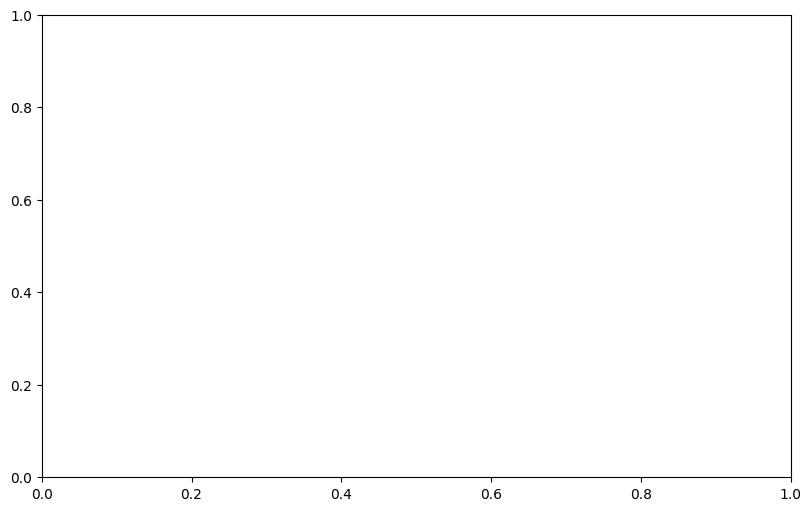

In [2]:
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
dem.plot(
    cmap="terrain", cbar_kwargs={"aspect": 50, "pad": 0.02, "label": "Elevation [m]"}
)
temperature.plot("t_max", ax=ax, cmap="RdBu_r", vmin=-15, vmax=15, edgecolor="k", s=50)
ax.set(title="Switzerland's topography and SwissMetNet stations", aspect="auto")
cb = fig.colorbar(ax.collections[-1], aspect=50, pad=0.02)
cb.set_label("Max. daily temperature [°C]", labelpad=-2)

As always, we store our training data in a `Dataset` object.

In [ ]:
x = temperature[["latitude", "longitude", "elevation"]].values
y = temperature[["t_max"]].values
D = Dataset(
    X=jnp.array(x),
    y=jnp.array(y),
)

## ARD Kernel
As temperature decreases with height
(at a rate of approximately -6.5 °C/km in average conditions), we can expect that using the geographical distance
alone isn't enough to to a decent job at interpolating this data. Therefore, we can also use elevation and optimize
the parameters of our kernel such that more relevance should be given to elevation. This is possible by using a
kernel that has one length-scale parameter per input dimension: an automatic relevance determination (ARD) kernel.
See our [kernel notebook](https://docs.jaxgaussianprocesses.com/examples/constructing_new_kernels/) for more an introduction to
kernels in GPJax.

In [ ]:
kernel = gpx.kernels.RBF(
    active_dims=[0, 1, 2],
    lengthscale=jnp.array([0.1, 0.1, 100.0]),
)

## Mean function
As stated before, we already know that temperature strongly depends on elevation.
So why not use it for our mean function? GPJax lets you define custom mean functions;
simply subclass `AbstractMeanFunction`.

In [ ]:
@dataclass
class MeanFunction(gpx.gps.AbstractMeanFunction):
    w: Float[Array, "1"] = param_field(jnp.array([0.0]))
    b: Float[Array, "1"] = param_field(jnp.array([0.0]))

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N 1"]:
        elevation = x[:, 2:3]
        out = elevation * self.w + self.b
        return out

Now we can define our prior. We'll also choose a Gaussian likelihood.

In [ ]:
mean_function = MeanFunction()
prior = gpx.Prior(kernel=kernel, mean_function=mean_function)
likelihood = gpx.Gaussian(D.n)

Finally, we construct the posterior.

In [ ]:
posterior = prior * likelihood

## Model fitting
We proceed to train our model. Because we used a Gaussian likelihood, the resulting posterior is
a `ConjugatePosterior`, which allows us to optimize the analytically expressed marginal loglikelihood.

As always, we can jit-compile the objective function to speed things up.

In [ ]:
negative_mll = jax.jit(gpx.objectives.ConjugateMLL(negative=True))
negative_mll(posterior, train_data=D)

In [ ]:
#optim = ox.chain(ox.adam(learning_rate=0.1), ox.clip(1.0))
posterior, history = gpx.fit(
    model=posterior,
    train_data=D,
    solver=jaxopt.LBFGS(gpx.ConjugateMLL(negative=True), maxiter=10),
    safe=True,
    key=key,
)
posterior: gpx.gps.ConjugatePosterior

## Sampling on a grid
Now comes the cool part. In a standard GP implementation, for n test points, we have a $\mathcal{O}(n^2)$
computational complexity and $\mathcal{O}(n^2)$ memory requirement. We want to make predictions on a total
of roughly 70'000 pixels, and that would require us to compute a covariance matrix of `70000 ** 2 = 4900000000` elements.
If these are `float64`s, as it is often the case in GPJax, it would be equivalent to more than 36 Gigabytes of memory. And
that's for a fairly coarse and tiny grid. If we were to make predictions on a 1000x1000 grid, the total memory required
would be 8 _Terabytes_ of memory, which is intractable.
Fortunately, the pathwise conditioning method allows us to sample from our posterior in linear complexity,
$\mathcal{O}(n)$, with the number of pixels.

GPJax provides the `sample_approx` method to generate random conditioned samples from our posterior.

In [ ]:
# select the target pixels and exclude nans
xtest = dem.drop("spatial_ref").stack(p=["y", "x"]).to_dataframe(name="dem")
mask = jnp.any(jnp.isnan(xtest.values), axis=-1)

# generate 50 samples
ytest = posterior.sample_approx(50, D, key, num_features=200)(
    jnp.array(xtest.values[~mask])
)

Let's take a look at the results. We start with the mean and standard deviation.

In [ ]:
predtest = xr.zeros_like(dem.stack(p=["y", "x"])) * jnp.nan
predtest[~mask] = ytest.mean(axis=-1)
predtest = predtest.unstack()

predtest.plot(
    vmin=-15.0,
    vmax=15.0,
    cmap="RdBu_r",
    cbar_kwargs={"aspect": 50, "pad": 0.02, "label": "Max. daily temperature [°C]"},
)
plt.gca().set_title("Interpolated maximum daily temperature")

In [ ]:
predtest = xr.zeros_like(dem.stack(p=["y", "x"])) * jnp.nan
predtest[~mask] = ytest.std(axis=-1)
predtest = predtest.unstack()

# plot
predtest.plot(
    cbar_kwargs={"aspect": 50, "pad": 0.02, "label": "Standard deviation [°C]"},
)
plt.gca().set_title("Standard deviation")

And now some individual realizations of our GP posterior.

In [ ]:
predtest = (
    xr.zeros_like(dem.stack(p=["y", "x"]))
    .expand_dims(realization=range(9))
    .transpose("p", "realization")
    .copy()
)
predtest[~mask] = ytest[:, :9]
predtest = predtest.unstack()
predtest.plot(
    col="realization",
    col_wrap=3,
    cbar_kwargs={"aspect": 50, "pad": 0.02, "label": "Max. daily temperature [°C]"},
)

Remember when we said that on average the temperature decreases with height at a rate
of approximately -6.5°C/km? That's -0.0065°C/m. The `w` parameter of our mean function
is very close: we have learned the environmental lapse rate!

In [ ]:
print(posterior.prior.mean_function)

That's it! We've successfully interpolated an observed meteorological parameter on a grid.
We have used several components of GPJax and adapted them to our needs: a custom mean function
that modelled the average temperature lapse rate; an ARD kernel that learned to give more relevance
to elevation rather than horizontal distance; an efficient sampling technique to produce
probabilistic realizations of our posterior on a large number of test points, which is important for
many spatiotemporal modelling applications.
If you're interested in a more elaborate work on temperature interpolation for the same domain used here, refer
to [Frei 2014](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.3786).

## System configuration

In [ ]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Francesco Zanetta'